In [1]:
import os
# import sys
# sys.path.append('../../../gene_program_evaluation/gene_network_evaluation/src')
# from inference.program_models import run_consensus_NMF_, run_cnmf_factorization, run_cnmf_consensus, init_cnmf_obj

import math

import mudata
import scanpy as scp

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.stats.multitest import fdrcorrection
from statsmodels.regression.mixed_linear_model import MixedLM

from joblib import Parallel, delayed
from tqdm.auto import tqdm

/home/users/ymo/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Motif

In [ ]:
# Import motif enrichments
motif_enrichment_data = []

path = '/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Results/torch-cNMF_evaluation/100k_cells_10iter_torch_mu_batch/Eval/30'
for fil in os.listdir(path):
    if 'motif_enrichment' in fil:
        motif_enrichment_data_ = pd.read_csv('{}/{}'.format(path,fil), sep='\t')
        motif_enrichment_data_['sample'] = fil.split('sample_')[-1].split('_motif')[0]
        if 'promoter' in fil:
            motif_enrichment_data_['class'] = 'promoter'
        elif 'enhancer' in fil:
            motif_enrichment_data_['class'] = 'enhancer'            

        motif_enrichment_data.append(motif_enrichment_data_)

motif_enrichment_data = pd.concat(motif_enrichment_data, ignore_index=True)
motif_enrichment_data.to_csv(f'{path}/cNMF_30_motif_enrichment.txt', sep='\t')
motif_enrichment_data.loc[motif_enrichment_data['class']=='promoter'].to_csv(f'{path}/cNMF_30_motif_enrichment_promoter.txt', sep='\t')
motif_enrichment_data.loc[motif_enrichment_data['class']=='enhancer'].to_csv(f'{path}/cNMF_30_motif_enrichment_enhancer.txt', sep='\t')


# Make summary table column
for seq_class in ['promoter', 'enhancer']:
    motif_enrichment_data_ = motif_enrichment_data.loc[motif_enrichment_data['class']==seq_class]
    motif_enrichment_data_ = motif_enrichment_data_.groupby(['sample', 'program_name', 'motif']).min().reset_index()

    motif_summary_data = pd.DataFrame(index=motif_enrichment_data_.program_name.unique(), columns=['top10_motifs', 'num_enriched_motifs'])
    for prog in motif_enrichment_data_.program_name.unique():
        motif_summary_data_ = motif_enrichment_data_.loc[(motif_enrichment_data_.program_name==prog) & ((motif_enrichment_data_.adj_pval<=0.05))]
        motif_summary_data_ = motif_summary_data_.sort_values('stat', ascending=False).head(10).motif.values
        motif_summary_data.loc[prog,'top10_motifs'] = ', '.join(motif_summary_data_.tolist())
        motif_summary_data.loc[prog, 'num_enriched_motifs'] = motif_enrichment_data_.loc[(motif_enrichment_data_.program_name==prog) & ((motif_enrichment_data_.adj_pval<=0.05))].shape[0]
        
    motif_summary_data.to_csv('motif_summary_data_{}.txt'.format(seq_class), sep='\t')

In [ ]:
# # Copy out to dashboard
# out_dir = '../../shared/250110_ipsc_ec_dashboard_setup/cNMF_100/'
# for fil in os.listdir('cNMF_100'):
#     if 'motif_' in fil:
#         class_ = fil.split('_')[1]
#         name = fil.split('_sample_')[1]
#         new_nam = f'cNMF_100_{class_}_test_pearsonr_sample_{name}'
#         if not name.startswith('D0'):
#             new_nam = new_nam.replace('sample_', 'sample_sample_')
#         os.system('cp {} {}'.format(os.path.join('cNMF_100', fil),
#                                     os.path.join(out_dir, new_nam)))

# Stability & Error

In [52]:
output_directory = '/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Results/torch-cNMF_evaluation/'
run_name = "100k_cells_10iter_torch_mu_batch"
components = [30, 50, 60, 80, 100, 200, 250, 300]

import cnmf
import scanpy as sc


cnmf_obj = cnmf.cNMF(output_dir=output_directory, name=run_name)

stats = []
norm_counts = sc.read(cnmf_obj.paths['normalized_counts'])
for k in components:
    stats.append(cnmf_obj.consensus(k, skip_density_and_return_after_stats=True,show_clustering=False, close_clustergram_fig=True,norm_counts=norm_counts).stats)

stats = pd.DataFrame(stats)

CUDA is not available on your machine. Use CPU mode instead.
CUDA is not available on your machine. Use CPU mode instead.
CUDA is not available on your machine. Use CPU mode instead.
CUDA is not available on your machine. Use CPU mode instead.
CUDA is not available on your machine. Use CPU mode instead.
CUDA is not available on your machine. Use CPU mode instead.
CUDA is not available on your machine. Use CPU mode instead.
CUDA is not available on your machine. Use CPU mode instead.


In [53]:
print(stats['silhouette'].min())
print(stats['silhouette'].max())

print(stats['prediction_error'].min())
print(stats['prediction_error'].max())

0.17301903665065765
0.3198544681072235
438329201.9523015
462457428.51395535


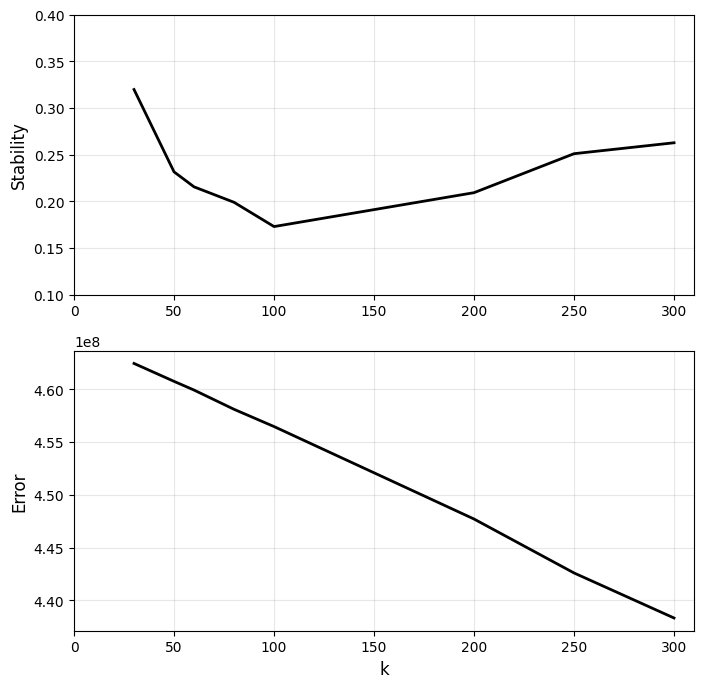

In [55]:
# Create the plot with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Top subplot - Stability (using silhouette as stability metric)
ax1.plot(stats['k'], stats['silhouette'], 'k-', linewidth=2)
ax1.set_ylabel('Stability', fontsize=12)
ax1.set_xlim(0, 310)
ax1.set_ylim(0.1, 0.4)  # Adjust based on your data range
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=10)

# Bottom subplot - Error (using prediction_error)
ax2.plot(stats['k'], stats['prediction_error'], 'k-', linewidth=2)
ax2.set_xlabel('k', fontsize=12)
ax2.set_ylabel('Error', fontsize=12)
ax2.set_xlim(0, 310)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', which='major', labelsize=10)

# Enrichement tests

In [66]:
folder = "/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Results/torch-cNMF_evaluation/100k_cells_10iter_torch_mu_batch/Eval"

In [68]:
# Load data
def load(k, term, path):
    df = pd.read_csv(path, sep='\t')
    df = df.loc[df['Adjusted P-value']<=0.05]
    df['num_programs'] = k
    df['test_term'] = term
    return df

components = [30, 60, 80, 100, 200, 250, 300]
term_df = []

for k in components:

    term_df.append(load(k, 'go_terms', '{}/{}/{}_GO_term_enrichment.txt'.format(folder,k,k)))
    term_df.append(load(k, 'genesets', '{}/{}/{}_geneset_enrichment.txt'.format(folder,k,k)))
    term_df.append(load(k, 'traits', '{}/{}/{}_trait_enrichment.txt'.format(folder,k,k)))
    #term_df.append(load(k, 'motifs', '{}/{}_motif_enrichment.txt'.format(k),k))   

term_df = pd.concat(term_df, ignore_index=True)


# Count unique terms per k
count_df = pd.DataFrame(index=components, columns=term_df['test_term'].unique())

for k in components:
    for col in count_df.columns:
        count_df.loc[k, col] = term_df.loc[(term_df['num_programs']==k) & (term_df['test_term']==col), 'Term'].unique().shape[0]

In [69]:
print(count_df['go_terms'].min())
print(count_df['go_terms'].max())

print(count_df['genesets'].min())
print(count_df['genesets'].max())

print(count_df['traits'].min())
print(count_df['traits'].max())


656
769
396
496
257
330


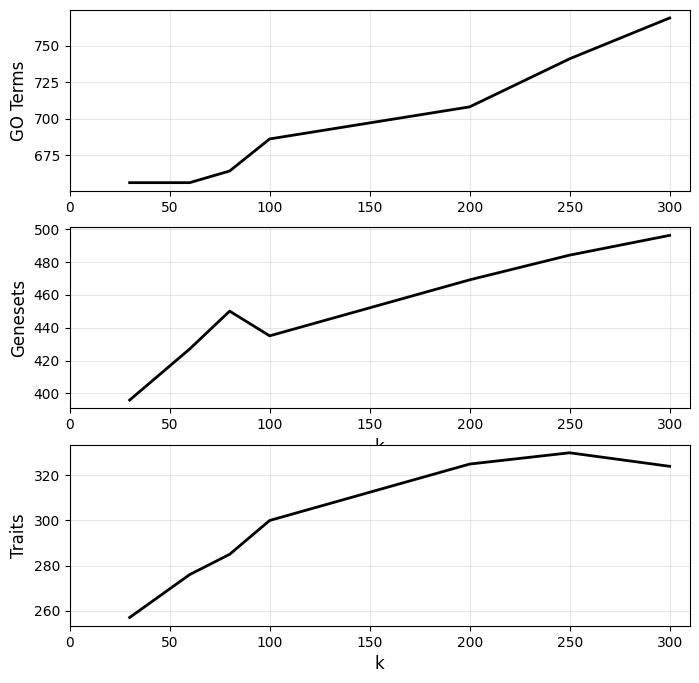

In [71]:
# Create the plot with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

# Top subplot - Stability (using silhouette as stability metric)
ax1.plot(count_df.index, count_df['go_terms'], 'k-', linewidth=2)
ax1.set_ylabel('GO Terms', fontsize=12)
ax1.set_xlim(0, 310)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=10)

# Bottom subplot - Error (using prediction_error)
ax2.plot(count_df.index, count_df['genesets'], 'k-', linewidth=2)
ax2.set_xlabel('k', fontsize=12)
ax2.set_ylabel('Genesets', fontsize=12)
ax2.set_xlim(0, 310)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', which='major', labelsize=10)

# Bottom subplot - Error (using prediction_error)
ax3.plot(count_df.index, count_df['traits'], 'k-', linewidth=2)
ax3.set_xlabel('k', fontsize=12)
ax3.set_ylabel('Traits', fontsize=12)
ax3.set_xlim(0, 310)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='both', which='major', labelsize=10)

# Perturbation

In [72]:
# Compute no. of unique regulators

test_stats_df = []
for k in [30, 60, 80, 100, 200, 250, 300]:  

    # Run perturbation assocation
    for samp in ['D0', 'sample_D1', 'sample_D2', 'sample_D3']:
        test_stats_df_ = pd.read_csv('{}/{}/{}_perturbation_association_results_{}.txt'.format(folder,k,k,samp), sep='\t')
        test_stats_df_['sample'] = samp
        test_stats_df_['K'] = k
        test_stats_df_['fdr'] = fdrcorrection(test_stats_df_['pval'])[1]
        test_stats_df.append(test_stats_df_)
test_stats_df = pd.concat(test_stats_df, ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: '/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Results/torch-cNMF_evaluation/100k_cells_10iter_torch_mu_batch/Eval/60/60_perturbation_association_results_D0.txt'

In [73]:
plotting_df

,K,target_name
0,30,187
1,60,217
2,80,211
3,100,216
4,200,229
5,250,237
6,300,238


187
238


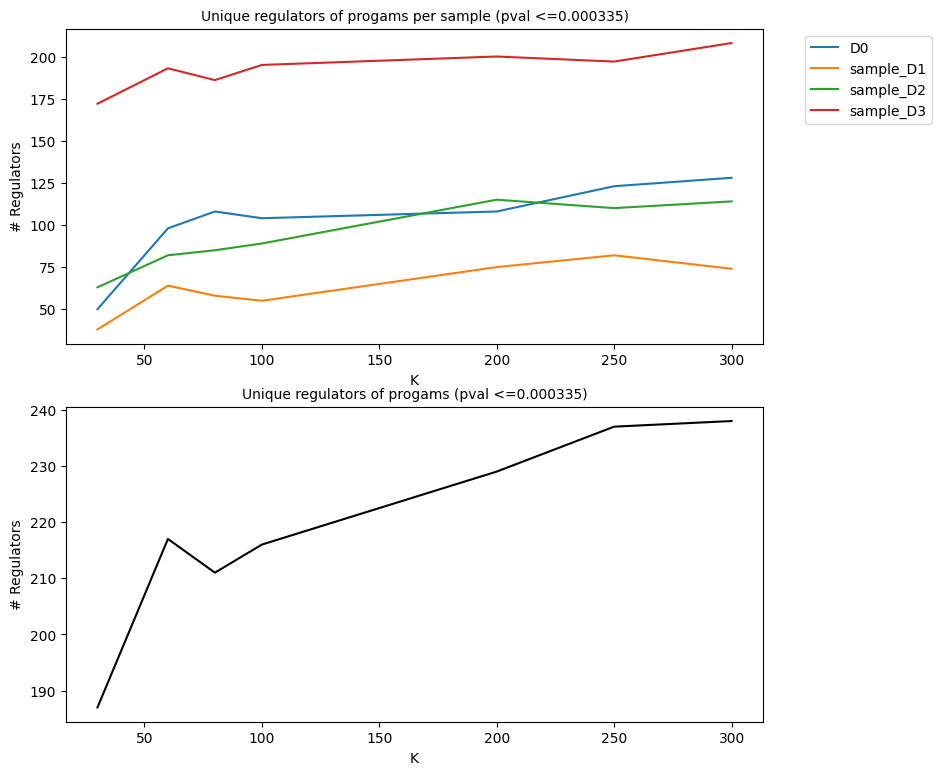

In [51]:
# Perturbation sensitivity 

fig, axs = plt.subplots(ncols=1, nrows=2,figsize=(9, 9))

axs[0].set_title('Unique regulators of progams per sample (pval <=0.000335)', fontsize=10)
plotting_df = test_stats_df.loc[test_stats_df.pval<=0.000335, ['K', 'sample','target_name']].drop_duplicates().groupby(['K', 'sample']).count().reset_index()
sns.lineplot(x='K', y='target_name', hue='sample', data=plotting_df, ax=axs[0])
axs[0].set_ylabel('# Regulators', fontsize=10)
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')


axs[1].set_title('Unique regulators of progams (pval <=0.000335)', fontsize=10)
plotting_df = test_stats_df.loc[test_stats_df.pval<=0.000335, ['K','target_name']].drop_duplicates().groupby(['K']).count().reset_index()
sns.lineplot(x='K', y='target_name', data=plotting_df, color='black', ax=axs[1])
axs[1].set_ylabel('# Regulators', fontsize=10)


print(plotting_df["target_name"].min())
print(plotting_df["target_name"].max())



In [ ]:
# Select significant K

'''
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,7))


# Perturbation sensitivity 
axs.flat[0].set_title('Unique regulators of progams (pval <=0.000335)')
plotting_df = test_stats_df.loc[test_stats_df.pval<=0.000335, ['K', 'sample','target_name']].drop_duplicates().groupby(['K', 'sample']).count().reset_index()
sns.lineplot(x='K', y='target_name', hue='sample', data=plotting_df, ax=axs.flat[0])

plotting_df = test_stats_df.loc[test_stats_df.pval<=0.000335, ['K','target_name']].drop_duplicates().groupby(['K']).count().reset_index()
sns.lineplot(x='K', y='target_name', data=plotting_df, color='black', ax=axs.flat[0])


# Unique GO Terms
sns.scatterplot(x='index', y='go_terms', data=count_df.reset_index(), ax=axs.flat[1], color='black')
sns.lineplot(x='index', y='go_terms', data=count_df.reset_index(), ax=axs.flat[1], color='black')
axs.flat[1].set_title('Unique GO Terms per num programs')

# Unique Gene sets
sns.scatterplot(x='index', y='genesets', data=count_df.reset_index(), ax=axs.flat[2], color='black')
sns.lineplot(x='index', y='genesets', data=count_df.reset_index(), ax=axs.flat[2], color='black')
axs.flat[2].set_title('Unique genesets per num programs')

# Unique Traits
sns.scatterplot(x='index', y='traits', data=count_df.reset_index(), ax=axs.flat[3], color='black')
sns.lineplot(x='index', y='traits', data=count_df.reset_index(), ax=axs.flat[3], color='black')
axs.flat[3].set_title('Unique traits per num programs')

# Unique Motifs
sns.scatterplot(x='index', y='motifs', data=count_df.reset_index(), ax=axs.flat[5], color='black')
sns.lineplot(x='index', y='motifs', data=count_df.reset_index(), ax=axs.flat[5], color='black')
axs.flat[4].set_title('Unique motifs per num programs')


for ax in axs.flat[:]:
    ax.set_xlabel('')
    ax.set_ylabel('')
axs.flat[-1].axis('off')

plt.tight_layout()
plt.savefig(f'{folder}/cNMF_k_selection_evaluations.png', dpi=100)


'''